In [34]:
import torch
import numpy as np
from pathlib import Path
from cartesian_polar.exp_autoencoder.agent import Autoencoder
import random
import matplotlib.pyplot as plt
import tqdm
from environment import DuplicatedCoordsEnv
import pandas as pd
import itertools
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import normalize, StandardScaler
import pickle

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
save_path = Path("save")
save_path.exists()

True

In [4]:
data_dir_ew = save_path / "7-30-A-10-EW-2"
print(data_dir_ew.exists())

True


In [5]:
data_path_ew = data_dir_ew / "data.tar"
print(data_path_ew.exists())

True


In [6]:
data_dict_ew = torch.load(data_path_ew, weights_only=False, map_location=DEVICE)
data_dict_ew.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

In [7]:
# ASSUMING EQUAL ARCHITECTURES
parameters = data_dict_ew['p']
n_observations = parameters.n_observations
n_actions = parameters.n_actions
n_units = parameters.n_hidden_units
bottleneck = parameters.bottleneck

In [8]:
env = data_dict_ew['env'] # assuming equal environments

## Helper Functions

In [9]:
"""
Function for converting angle degree to cardinal direction
"""
def degrees_to_cardinal(degree):
    # Normalize the degree to [0, 360)
    degree = degree % 360

    # Define the mapping
    directions = {
        0: 'N',
        90: 'E',
        180: 'S',
        270: 'W'
    }

    # Find the closest cardinal angle
    closest = min(directions.keys(), key=lambda x: abs(x - degree))
    return directions[closest]

In [10]:
def convert_state_sample_to_orig_sample(state_sample):
    orig_state_samples = []
    for state in state_sample:

        if state[0].item() == 1:
            odor_cue = 'No Odor'
        elif state[1].item() == 1:
            odor_cue = 'Odor A'
        else:
            odor_cue = 'Odor B'

        coords_orig = env.conv_north_cartesian2orig(state[3:7]).tolist()
        coords_orig.insert(0, odor_cue)
        
        head_deg = coords_orig[3]
        head_cardinal = degrees_to_cardinal(head_deg)
        coords_orig[3] = head_cardinal
        
        coords_orig.append(state[3].item()) # CNP x
        coords_orig.append(state[4].item()) # CNP y
        coords_orig.append(state[7].item()) # CSP x
        coords_orig.append(state[8].item()) # CSP y

        orig_state_samples.append(coords_orig)
    return orig_state_samples

In [11]:
def get_layer_activations(net, input_states, layer_index):
    activations_list = []

    def hook(module, input, output):
        activations_list.append(output.detach().cpu().numpy().squeeze())

    # Register hook
    handle = list(net.mlp.children())[layer_index].register_forward_hook(hook)

    # Forward pass through each input state
    with torch.no_grad():
        for state in input_states:
            net(state)

    # Clean up hook
    handle.remove()

    # Stack into numpy array
    activations_array = np.stack(activations_list)  # Shape: (500, 512)

    return activations_array


In [12]:
def compute_centroids_by_category(activations, labels):
    centroids = {}
    for label in np.unique(labels):
        mask = labels == label
        centroids[label] = activations[mask].mean(axis=0)
    return centroids

## States

In [13]:
all_x = [-2, -1, 0, 1, 2]
all_y = [-2, -1, 0, 1, 2]
all_head = [0, 90, 180, 270]
all_odor = [torch.tensor(0), torch.tensor(1), torch.tensor(2)]

all_possible_states = list(itertools.product(all_odor, all_x, all_y, all_head))

state_dicts = [
    {'cue': odor, 'x': x, 'y': y, 'direction': hd}
    for (odor, x, y, hd) in all_possible_states
]

In [14]:
all_possible_tensors = []

for state_dict in state_dicts:
    state_tensor = DuplicatedCoordsEnv.conv_dict_to_flat_duplicated_coords(env, state_dict)
    all_possible_tensors.append(state_tensor)

In [15]:
print(len(all_possible_tensors))

300


## Max Activation Analysis

In [16]:
cat = data_dir_ew

# if cat == data_dir_lr:
#     cat_label = 'L/R'
# else:
#     cat_label = 'E/W'

model = Autoencoder(n_observations, n_actions, bottleneck, n_units)

model_path = cat / f'trained-agent-state-0.pt'
model.load_state_dict(torch.load(model_path, weights_only=False, map_location=torch.device('cpu')))
model.eval()

Autoencoder(
  (mlp): Sequential(
    (0): Linear(in_features=21, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [17]:
state_samples = all_possible_tensors

In [18]:
q_values = get_layer_activations(model, state_samples, 6)
chosen_actions = np.argmax(q_values, axis=1)

action_labels = ['Move Forward', 'Turn Left', 'Turn Right']
chosen_action_names = [action_labels[i] for i in chosen_actions]

In [19]:
orig_samples = convert_state_sample_to_orig_sample(state_sample=state_samples)
print(orig_samples)

upper_triangle_coords = [(-1,2), (0,2), (1,2), (2,2), (0,1), (1,1), (2,1), (1,0), (2,0), (2,-1)]
metadata = {
    "odor": [],
    "x": [],
    "y": [],
    "grid_pos": [],
    "head_dir": [],
    "action": [],
    "triangle": [],
    "CNP x": [],
    "CNP y": [],
    "CSP x": [],
    "CSP y": []
}

for state in orig_samples:
    metadata["odor"].append(state[0])
    metadata["x"].append(state[1])
    metadata["y"].append(state[2])
    metadata["grid_pos"].append((state[1], state[2]))
    metadata["head_dir"].append(state[3])
    if (state[1], state[2]) in upper_triangle_coords:
        metadata["triangle"].append('U')
    else:
        metadata["triangle"].append('L')
    metadata["CNP x"].append(state[4])
    metadata["CNP y"].append(state[5])
    metadata["CSP x"].append(state[6])
    metadata["CSP y"].append(state[7])
metadata["action"] = chosen_action_names

metadata_df = pd.DataFrame(metadata)
print(metadata_df.to_string())

[['No Odor', -2.0, -2.0, 'N', 4.0, 4.0, 0.0, 0.0], ['No Odor', -2.0, -2.0, 'E', 4.0, 4.0, 0.0, 0.0], ['No Odor', -2.0, -2.0, 'S', 4.0, 4.0, 0.0, 0.0], ['No Odor', -2.0, -2.0, 'W', 4.0, 4.0, 0.0, 0.0], ['No Odor', -2.0, -1.0, 'N', 4.0, 3.0, 0.0, 1.0], ['No Odor', -2.0, -1.0, 'E', 4.0, 3.0, 0.0, 1.0], ['No Odor', -2.0, -1.0, 'S', 4.0, 3.0, 0.0, 1.0], ['No Odor', -2.0, -1.0, 'W', 4.0, 3.0, 0.0, 1.0], ['No Odor', -2.0, 0.0, 'N', 4.0, 2.0, 0.0, 2.0], ['No Odor', -2.0, 0.0, 'E', 4.0, 2.0, 0.0, 2.0], ['No Odor', -2.0, 0.0, 'S', 4.0, 2.0, 0.0, 2.0], ['No Odor', -2.0, 0.0, 'W', 4.0, 2.0, 0.0, 2.0], ['No Odor', -2.0, 1.0, 'N', 4.0, 1.0, 0.0, 3.0], ['No Odor', -2.0, 1.0, 'E', 4.0, 1.0, 0.0, 3.0], ['No Odor', -2.0, 1.0, 'S', 4.0, 1.0, 0.0, 3.0], ['No Odor', -2.0, 1.0, 'W', 4.0, 1.0, 0.0, 3.0], ['No Odor', -2.0, 2.0, 'N', 4.0, 0.0, 0.0, 4.0], ['No Odor', -2.0, 2.0, 'E', 4.0, 0.0, 0.0, 4.0], ['No Odor', -2.0, 2.0, 'S', 4.0, 0.0, 0.0, 4.0], ['No Odor', -2.0, 2.0, 'W', 4.0, 0.0, 0.0, 4.0], ['No Odor',

In [20]:
activations = get_layer_activations(model, all_possible_tensors, 3)
print(activations)

[[0.         0.         1.5916139  ... 0.         0.62003106 1.0738117 ]
 [0.         0.         1.7223601  ... 0.         0.7009393  1.2904141 ]
 [0.         0.         1.7816436  ... 0.         0.7599737  1.2212774 ]
 ...
 [0.         0.         1.4133934  ... 0.         0.7794217  1.3829039 ]
 [0.         0.         1.1305768  ... 0.         0.25693318 1.5297276 ]
 [0.         0.         1.0316802  ... 0.         0.14525409 1.6749309 ]]


In [21]:
print(activations.shape)

(300, 10)


In [22]:
node_idx = 2
node_activations = activations[:, node_idx]
print(node_activations)

[1.5916139  1.7223601  1.7816436  1.6595454  1.5550059  1.591187
 1.61422    1.4567242  1.4174206  1.5143378  1.5235351  1.3328105
 1.3194882  1.5209306  1.4557537  1.1491933  1.2565178  1.4999237
 1.3951741  0.9841814  1.6049616  1.7124001  1.7498413  1.6317679
 1.5282477  1.5885338  1.6509503  1.4979721  1.4330815  1.5075109
 1.522916   1.3232007  1.3801221  1.5062741  1.4374657  1.141259
 1.2996663  1.5172428  1.3641268  0.97062707 1.6334361  1.722495
 1.7736334  1.6088492  1.5374194  1.6033179  1.6181839  1.4916079
 1.4705638  1.5111374  1.4500377  1.2834665  1.431738   1.5205239
 1.3887357  1.1039109  1.3414391  1.4956083  1.3355103  1.0421058
 1.6174749  1.7641829  1.7430583  1.5733694  1.5190822  1.6704967
 1.5351173  1.4085754  1.50466    1.5138997  1.36098    1.2244246
 1.4752399  1.4912527  1.2966799  1.1539038  1.3846433  1.4679617
 1.2527684  1.0647892  1.6307887  1.840695   1.7131119  1.4941711
 1.5634221  1.7180758  1.5230008  1.328242   1.5435072  1.5431784
 1.346547   1

In [23]:
# Get sorted indices in descending order
sorted_indices = np.argsort(-node_activations)  # minus sign for descending sort

# Grab top-k rows from metadata
top_k = 50
topk_metadata = metadata_df.iloc[sorted_indices[:top_k]]
topk_activations = node_activations[sorted_indices[:top_k]]

In [24]:
topk_metadata

,odor,x,y,grid_pos,head_dir,action,triangle,CNP x,CNP y,CSP x,CSP y
281,Odor B,2.0,-2.0,"(2.0, -2.0)",E,Move Forward,L,0.0,4.0,4.0,0.0
242,Odor B,0.0,-2.0,"(0.0, -2.0)",S,Turn Left,L,2.0,4.0,2.0,0.0
262,Odor B,1.0,-2.0,"(1.0, -2.0)",S,Move Forward,L,1.0,4.0,3.0,0.0
261,Odor B,1.0,-2.0,"(1.0, -2.0)",E,Move Forward,L,1.0,4.0,3.0,0.0
282,Odor B,2.0,-2.0,"(2.0, -2.0)",S,Move Forward,L,0.0,4.0,4.0,0.0
81,No Odor,2.0,-2.0,"(2.0, -2.0)",E,Turn Right,L,0.0,4.0,4.0,0.0
202,Odor B,-2.0,-2.0,"(-2.0, -2.0)",S,Turn Left,L,4.0,4.0,0.0,0.0
222,Odor B,-1.0,-2.0,"(-1.0, -2.0)",S,Turn Left,L,3.0,4.0,1.0,0.0
241,Odor B,0.0,-2.0,"(0.0, -2.0)",E,Move Forward,L,2.0,4.0,2.0,0.0
2,No Odor,-2.0,-2.0,"(-2.0, -2.0)",S,Turn Right,L,4.0,4.0,0.0,0.0


In [25]:
topk_activations

array([1.9257625, 1.8899856, 1.8886554, 1.8801159, 1.8558645, 1.840695 ,
       1.839363 , 1.8371176, 1.8025833, 1.7816436, 1.7736334, 1.7701623,
       1.7641829, 1.763786 , 1.7498413, 1.7497352, 1.7463951, 1.7430583,
       1.722495 , 1.7223601, 1.7180758, 1.7159011, 1.7131119, 1.7124001,
       1.7120231, 1.7119495, 1.7104394, 1.7041627, 1.7034568, 1.6989623,
       1.68643  , 1.6842555, 1.6793965, 1.6729456, 1.6704967, 1.6681153,
       1.6595454, 1.6509503, 1.6508825, 1.6423057, 1.639803 , 1.6334361,
       1.6333895, 1.6317679, 1.6307887, 1.6181839, 1.6174749, 1.61422  ,
       1.6122415, 1.6097448], dtype=float32)

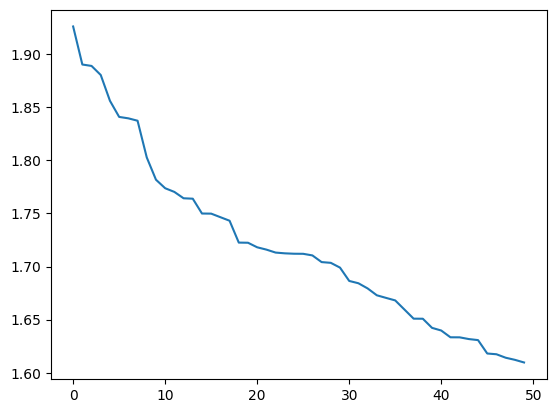

In [26]:
# Color by Odor cue, perhaps other metadata

plt.plot(topk_activations)

In [39]:
small_metadata = topk_metadata[['odor', 'x', 'y', 'head_dir', 'triangle']]
small_metadata.rename(columns={'head_dir': 'heading', 'triangle': 'UpperTriangle'}, inplace=True)
small_metadata['UpperTriangle'] = small_metadata['UpperTriangle'] == 'U'
print(small_metadata)

        odor    x    y heading  UpperTriangle
281   Odor B  2.0 -2.0       E          False
242   Odor B  0.0 -2.0       S          False
262   Odor B  1.0 -2.0       S          False
261   Odor B  1.0 -2.0       E          False
282   Odor B  2.0 -2.0       S          False
81   No Odor  2.0 -2.0       E          False
202   Odor B -2.0 -2.0       S          False
222   Odor B -1.0 -2.0       S          False
241   Odor B  0.0 -2.0       E          False
2    No Odor -2.0 -2.0       S          False
42   No Odor  0.0 -2.0       S          False
280   Odor B  2.0 -2.0       N          False
61   No Odor  1.0 -2.0       E          False
285   Odor B  2.0 -1.0       E           True
22   No Odor -1.0 -2.0       S          False
221   Odor B -1.0 -2.0       E          False
260   Odor B  1.0 -2.0       N          False
62   No Odor  1.0 -2.0       S          False
41   No Odor  0.0 -2.0       E          False
1    No Odor -2.0 -2.0       E          False
85   No Odor  2.0 -1.0       E    

/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_48914/2663247851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata.rename(columns={'head_dir': 'heading', 'triangle': 'UpperTriangle'}, inplace=True)
/var/folders/q_/5jhl26b10bjfk3kgkd_9b7zc0000gn/T/ipykernel_48914/2663247851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata['UpperTriangle'] = small_metadata['UpperTriangle'] == 'U'


In [40]:
topk_dict = small_metadata.to_dict(orient="records")
print(topk_dict)

[{'odor': 'Odor B', 'x': 2.0, 'y': -2.0, 'heading': 'E', 'UpperTriangle': False}, {'odor': 'Odor B', 'x': 0.0, 'y': -2.0, 'heading': 'S', 'UpperTriangle': False}, {'odor': 'Odor B', 'x': 1.0, 'y': -2.0, 'heading': 'S', 'UpperTriangle': False}, {'odor': 'Odor B', 'x': 1.0, 'y': -2.0, 'heading': 'E', 'UpperTriangle': False}, {'odor': 'Odor B', 'x': 2.0, 'y': -2.0, 'heading': 'S', 'UpperTriangle': False}, {'odor': 'No Odor', 'x': 2.0, 'y': -2.0, 'heading': 'E', 'UpperTriangle': False}, {'odor': 'Odor B', 'x': -2.0, 'y': -2.0, 'heading': 'S', 'UpperTriangle': False}, {'odor': 'Odor B', 'x': -1.0, 'y': -2.0, 'heading': 'S', 'UpperTriangle': False}, {'odor': 'Odor B', 'x': 0.0, 'y': -2.0, 'heading': 'E', 'UpperTriangle': False}, {'odor': 'No Odor', 'x': -2.0, 'y': -2.0, 'heading': 'S', 'UpperTriangle': False}, {'odor': 'No Odor', 'x': 0.0, 'y': -2.0, 'heading': 'S', 'UpperTriangle': False}, {'odor': 'Odor B', 'x': 2.0, 'y': -2.0, 'heading': 'N', 'UpperTriangle': False}, {'odor': 'No Odor', '

In [41]:
with open("../topk_dict.pkl", "wb") as f:
    pickle.dump(topk_dict, f)